In [1]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.16.1


In [3]:
# Define parameters
batch_size = 32
img_height = 224
img_width = 224
data_dir = '/kaggle/input/covid19-detection/Data'
temp_data_dir = '/kaggle/working/filtered_data'
num_files = 3500

In [4]:
# Clean up and create temporary directory
if os.path.exists(temp_data_dir):
    shutil.rmtree(temp_data_dir)
os.makedirs(temp_data_dir, exist_ok=True)


# Splitting and balancing data among different classes

In [5]:
# Create symbolic links for a subset of files
for sub_dir in os.listdir(data_dir):
    full_sub_dir = os.path.join(data_dir, sub_dir)
    if os.path.isdir(full_sub_dir) and sub_dir != 'Fibrosis':
        temp_sub_dir = os.path.join(temp_data_dir, sub_dir)
        os.makedirs(temp_sub_dir, exist_ok=True)
        all_files = os.listdir(full_sub_dir)
        selected_files = random.sample(all_files, min(num_files, len(all_files)))
        for file_name in selected_files:
            full_file_path = os.path.join(full_sub_dir, file_name)
            temp_file_path = os.path.join(temp_sub_dir, file_name)
            os.symlink(full_file_path, temp_file_path)


In [6]:
# Load datasets with data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:

train = tf.keras.utils.image_dataset_from_directory(temp_data_dir, image_size=(img_height, img_width),
                                                     validation_split=0.1, subset='training', seed=123,
                                                     batch_size=batch_size)

val = tf.keras.utils.image_dataset_from_directory(temp_data_dir, image_size=(img_height, img_width),
                                                   validation_split=0.2, subset='validation', seed=123,
                                                   batch_size=batch_size)


Found 14000 files belonging to 4 classes.
Using 12600 files for training.
Found 14000 files belonging to 4 classes.
Using 2800 files for validation.


In [8]:
label_to_class_name = dict(zip(range(len(train.class_names)), train.class_names))
label_to_class_name

{0: 'COVID', 1: 'Normal', 2: 'PNEUMONIA', 3: 'Tuberculosis'}

In [9]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


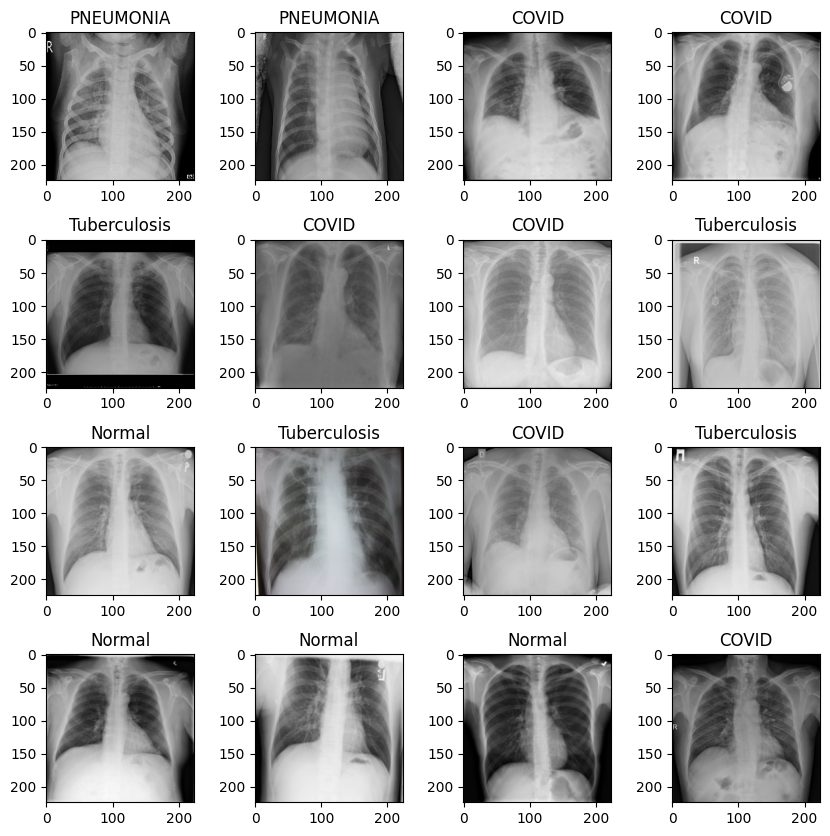

In [10]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):  
    for j in range(4):  
        index = i * 4 + j  
        ax[i, j].imshow(batch[0][index].astype(int))
        ax[i, j].set_title(label_to_class_name[batch[1][index]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [11]:
def augment_image(image):
    # Convert image to float32 if it's not already
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Apply random transformations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Optionally resize or crop the image
    image = tf.image.resize_with_crop_or_pad(image, target_height=224, target_width=224)
    
    return image


In [12]:
# Apply the transformations to the train dataset
train = train.map(lambda x, y: (augment_image(x), y))

# Normalize validation dataset
val = val.map(lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), y))

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

# Resnet_model

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [15]:
print(tf.__version__)

2.16.1


In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)
resnet_model = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

# Freeze more layers to start with
for layer in resnet_model.layers[:140]:
    layer.trainable = False

x = GlobalAveragePooling2D()(resnet_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-3))(x)  # Increase regularization
x = BatchNormalization()(x)  # Add Batch Normalization
x = Dropout(0.6)(x)  # Increase Dropout rate
output = Dense(4, activation='softmax')(x)

resnet_net = Model(inputs=resnet_model.input, outputs=output)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
# Use a smaller learning rate and apply gradient clipping
optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)
resnet_net.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [18]:
resnet_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 14,978,048 (57.14 MB)

 Non-trainable params: 8,609,664 (32.84 MB)

In [19]:
# Callbacks for learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [20]:
history = resnet_net.fit(
    train, 
    epochs=15, 
    validation_data=val, 
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/15


I0000 00:00:1726266410.501902     110 service.cc:145] XLA service 0x797d7c13b1e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726266410.501986     110 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726266410.501995     110 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/394 ━━━━━━━━━━━━━━━━━━━━ 3:09:42 29s/step - accuracy: 0.1562 - loss: 3.6115

I0000 00:00:1726266424.840852     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


394/394 ━━━━━━━━━━━━━━━━━━━━ 109s 204ms/step - accuracy: 0.7921 - loss: 1.4658 - val_accuracy: 0.9521 - val_loss: 0.9547 - learning_rate: 1.0000e-04
Epoch 2/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 53s 135ms/step - accuracy: 0.9578 - loss: 0.9060 - val_accuracy: 0.9725 - val_loss: 0.8446 - learning_rate: 1.0000e-04
Epoch 3/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 53s 134ms/step - accuracy: 0.9832 - loss: 0.8025 - val_accuracy: 0.9768 - val_loss: 0.8165 - learning_rate: 1.0000e-04
Epoch 4/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 53s 135ms/step - accuracy: 0.9911 - loss: 0.7357 - val_accuracy: 0.9804 - val_loss: 0.7606 - learning_rate: 1.0000e-04
Epoch 5/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 53s 134ms/step - accuracy: 0.9938 - loss: 0.6830 - val_accuracy: 0.9589 - val_loss: 0.7970 - learning_rate: 1.0000e-04
Epoch 6/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 53s 135ms/step - accuracy: 0.9891 - loss: 0.6462 - val_accuracy: 0.9811 - val_loss: 0.6399 - learning_rate: 1.0000e-04
Epoch 7/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 53s 134ms/step -

In [21]:
# Save the model after initial training
resnet_net.save('resnet_initial_model.h5')

In [23]:
import pickle
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np


predictions = resnet_net.predict(val)

true_labels = np.concatenate([y for x, y in val], axis=0)

cm = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

with open('ResNet_confusion_matrix.pkl', 'wb') as f:
    pickle.dump(cm, f)


88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step


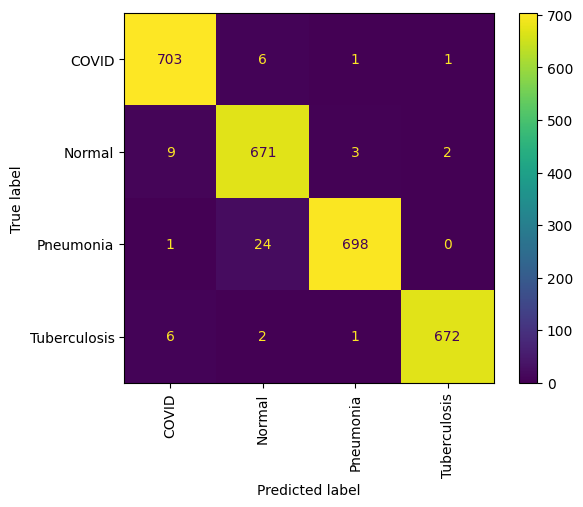

In [24]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Load the saved confusion matrix
with open('ResNet_confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

# Define class names (assuming you have them)
class_names = ['COVID', 'Normal', 'Pneumonia', 'Tuberculosis']   # Replace with your actual class names

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

# Show the confusion matrix plot
plt.show()


In [25]:
from sklearn.metrics import accuracy_score, f1_score
# Calculate accuracy
accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))
print(f'Accuracy: {accuracy:.4f}')

# Calculate F1 score (assuming you want the macro average)
f1 = f1_score(true_labels, np.argmax(predictions, axis=1), average='macro')
print(f'F1 Score (Macro): {f1:.4f}')


Accuracy: 0.9800
F1 Score (Macro): 0.9800


In [37]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [41]:
class_labels = {0: 'COVID', 1: 'Normal', 2: 'PNEUMONIA', 3: 'Tuberculosis'}

In [43]:
# Function to preprocess the input image
def preprocess_image(img_path, target_size=(224, 224)):
    """
    Preprocesses the image to feed into the model.
    
    Args:
    img_path (str): Path to the input image file.
    target_size (tuple): Size to resize the image (default is (224, 224) for ResNet).
    
    Returns:
    img_array (np.array): Preprocessed image ready for prediction.
    """
    img = image.load_img(img_path, target_size=target_size)  # Load and resize image
    img_array = image.img_to_array(img)                      # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)            # Add batch dimension
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)  # Preprocess as per ResNet requirements
    return img_array

# Function to make predictions and display the result
def predict_image(img_path, model, class_labels):
    """
    Predict the class of a single image using the trained model.
    
    Args:
    img_path (str): Path to the image file.
    model (tf.keras.Model): Trained Keras model for prediction.
    class_labels (dict): Mapping from class indices to class labels.
    
    Returns:
    prediction: The predicted class for the input image.
    """
    # Preprocess the image
    preprocessed_img = preprocess_image(img_path)
    
    # Make predictions
    predictions = model.predict(preprocessed_img)
    
    # Get the predicted class index
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    
    # Map the predicted class index to the actual class label
    predicted_class_label = class_labels[predicted_class_idx]
    
    # Display the image with the predicted class label
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_label}")
    plt.axis('off')
    plt.show()
    
    return predicted_class_label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


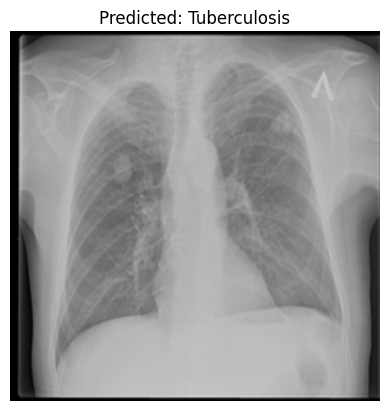

The model predicts this image belongs to class: Tuberculosis


In [49]:
# Replace 'image_path.jpg' with the path to your test image
predicted_class = predict_image('/kaggle/input/covid19-detection/Data/Tuberculosis/Tuberculosis-1012.png', resnet_net, class_labels)
print(f"The model predicts this image belongs to class: {predicted_class}")

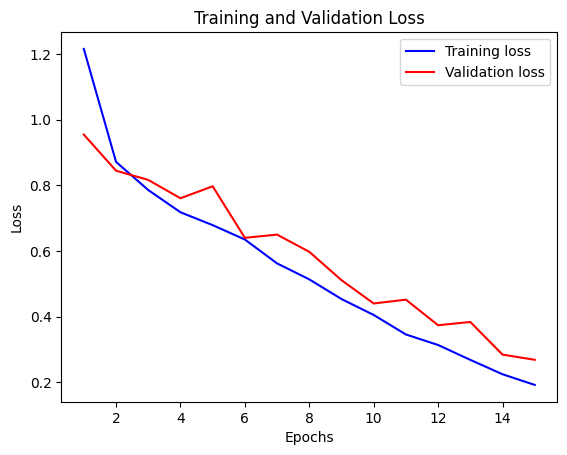

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

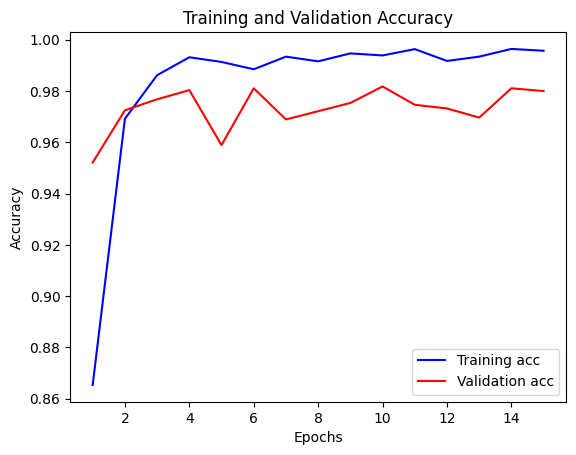

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()